# USCRP STONE: IG-SG Waves Lab Scaling

In [1]:
import netCDF4 as nc4
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
import warnings
import math

## Functions

Function to solve the dispersion relation (dispersi):

In [2]:
def dispersi(const):
    """
    Solve the linear dispersion relationship for surface gravity waves.

    Input:
        const = omega^2 * h / g, where:
            omega = radian frequency,
            h = water depth,
            g = acceleration due to gravity.
    Output:
        kh = wavenumber times water depth.
    Notes: Solves omega^2 * h / g = kh * tanh(kh) using Newton-Raphson iteration.
    
    Code to compute omega from frequency or period:
          g = 9.81
          omega = 2 * np.pi * f = 2 * np.pi / T
          const = (omega ** 2) * h / g
    Code to compute wavelength from kh:
          k = kh / h
          L = 2 * np.pi / k

    Code modified by C.M.Baker on Oct 2024
    """

    # Convert input to array, ensuring it's at least 1D
    const = np.atleast_1d(const)

    # Set negative values to NaN to avoid sqrt warning, assuming they are invalid
    const = np.where(const < 0, np.nan, const)

    # Initialize kh with zeros where const is zero, else with sqrt(const) as initial guess
    kh = np.where(const == 0, 0, np.sqrt(const))

    # Newton-Raphson iteration
    tolerance = 1e-6
    max_iterations = 100
    for _ in range(max_iterations):
        delta = (kh * np.tanh(kh) - const) / (np.tanh(kh) + kh / np.cosh(kh)**2)
        kh -= delta
        if np.all(np.abs(delta) < tolerance):
            break

    return kh

Function to angular frequency and wavenumber (calc_omega_k):

In [3]:
def calc_omega_k(f, h):
    """ 
    f = frequency
    h = water depth 
    
    Example usage:
    [omega, k] = calc_omega_k(frequency_value, water_depth_value)
    """
    
    # Constants
    g = 9.81
    
    # Angular frequency calculation
    omega = 2 * np.pi / (f ** (-1))
    
    # Constants calculation
    cons = omega ** 2 * h / g
    
    # Call to dispersi function (assuming it's defined elsewhere)
    kh = dispersi(cons)
    
    # Calculate k
    k = kh / h
    
    return omega, float(k)

Wave shoaling function

In [4]:
def waveshoal_h_nonmono(T, H0, theta0, gamma, h):
    """
    Code modified from M.Moulton on April 2, 2023
    """
    
    # Suppress RuntimeWarning
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4
    

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed
    k = 2 * np.pi / L  # Wavenumber
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0
    cg0 = cg[0]  # Phase speed at depth h0

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0]
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Store variables
    wave = {'h': h,
            'L': L,
            'Ldeep': Ldeep,
            'H': H,
            'c': c,
            'cg': cg,
            'theta': np.degrees(theta),
            'breaking_depth': breaking_depth,
            'breaking_height': breaking_height,
            'breaking_angle': breaking_angle,
            'breaking_index': breaking_index}

    # Compute profile onshore of breaking
    H[breaking_index] = h[breaking_index] * gamma
    binds = np.arange(breaking_index, len(h) - 1)

    for ii in binds:
        if h[ii + 1] < h[ii]:
            # Depth-limited breaking
            H[ii + 1] = h[ii + 1] * gamma
        else:
            # Re-shoaling)
            h_2 = h[ii:]
            H0_2 = H[ii]
            theta0_2 = np.degrees(theta[ii])

            wave_2 = waveshoal_subf(T, H0_2, theta0_2, gamma, h_2)

            H_2 = wave_2['H']
            theta_2 = wave_2['theta']
            breaking_index2 = wave_2['breaking_index']

            # Fill in values
            H[ii:] = H_2
            theta[ii:] = theta_2

            # Second breaking region
            H[ii + breaking_index2:] = h[ii + breaking_index2:] * gamma

            break

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan

    wave['H'] = H
    wave['theta'] = np.degrees(theta)
    
    # AReset the warnings
    warnings.resetwarnings()

    return wave

def waveshoal_subf(T, H0, theta0, gamma, h):
    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed
    k = 2 * np.pi / L  # Wavenumber
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0
    cg0 = cg[0]  # Phase speed at depth h0

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0]
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # Store variables
    wave_sub = {'h': h,
                'L': L,
                'Ldeep': Ldeep,
                'H': H,
                'c': c,
                'cg': cg,
                'theta': np.degrees(theta),
                'breaking_depth': breaking_depth,
                'breaking_height': breaking_height,
                'breaking_angle': breaking_angle,
                'breaking_index': breaking_index}

    return wave_sub

In [5]:
def find_closest_index(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

def indices_between(lst, lower_bound, upper_bound):
    between_indices = [i for i, x in enumerate(lst) if lower_bound < x < upper_bound]
    return between_indices

def ft2m(feet):
    meters = feet * 0.3048  # 1 foot is approximately equal to 0.3048 meters
    return meters

## Constants

- Density of sand: $\rho_s = 2650 $ kg/m$^3  = 2.65$ g/cm$^3$    
- Density of fresh fluid: $\rho_f = 997 $ kg/m$^3 = 0.997$ g/cm$^3$   
- Density difference: $\Delta \rho = \rho_s - \rho_f = 1653$ kg/m$^3 = 1.653$ g/cm$^3$  
- Specific density: $s = \frac{\rho_s}{\rho_f} = 2.65$
- Specific gravity: $s_g = \frac{\rho_s - \rho_f}{\rho_f} = 1.658$
- Gravity: $g = 9.81$ m/s$^2 = 980$ cm/s$^2$  
- Kinematic viscosity: $\mu = 0.00139 $ kg/m/s $= 0.0139$ g/cm/s (10$^{\circ}$C saltwater) 
- Dynamic viscosity: $\nu = \frac{\mu}{\rho_f} = 1.39 \times 10^{-6}$ m$^2$/s
- von Karmen's constant, $\kappa \approx 0.41$

In [6]:
# constants
rhos = 2650 # kg/m3
rhof = 997 # kg/m3
drho = rhos - rhof # kg/m3
g = 9.81 # m/s2
sdense = rhos / rhof # typ 2.65, specific density
sgrav = (rhos - rhof) / rhof # typ 1.65, specific gravity
mu = 0.00139 # kg/m/s
nu = mu / rhof # m2/s
kappa = 0.41

## Givens:

Wave and water level properties:
- Frequencies: $f_1, f_2$  
- Amplitudes: $a_1, a_2$  

Sediment properties:
- Sediment size: $d_{50} = 0.15$ mm

Lab domain

In [7]:
# define bichromatic wave and water properties
f1 = 0.5 # frequency 
f2 = 0.43 # frequency 
a1 = 0.05 # amplitude  
a2 = 0.05 # amplitude
swl = 1.2 #1.5 # still water level at the wavemaker
theta0 = 0 # wave direction relative to shore-normal
gammab = 0.5 # breaking threshold (H/h)

# define water level at the wavemaker
D50 = 0.15/1000 # m, median sediment size, model = 0.15

# lab domain
lab_slope = 1/32 #1/43.5 #1/32
lab_length = 63
lab_depth = 1.5 + 0.48 #1.2 + 0.48 #1.5+0.48
lab_beach = 1.36 #1.7

# Config 1: swl = 1.2, lab_slope = 1/43.5, lab_depth = 1.5 + 0.48

### Define bathymetry with givens

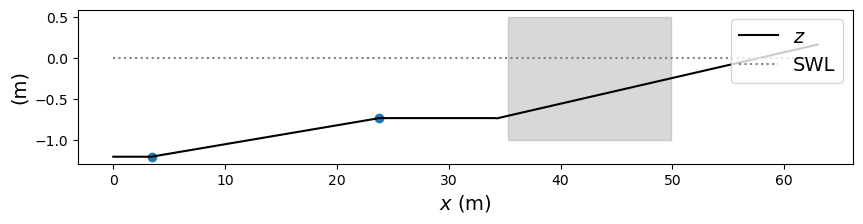

In [8]:
# setup bathymetry
dx = 0.1
x = np.arange(0, lab_length + dx, dx)
d = np.zeros_like(x)


# create experiment slope
ibeach = np.arange(int(len(x)-lab_beach / lab_slope / dx),len(x),1)
d[ibeach] = np.arange(dx * lab_slope, lab_beach + dx * lab_slope, dx * lab_slope)

# create offshore slope
slope_off = 1/43.5
off_depth = ft2m(66.7)*slope_off
ioffbeach = indices_between(x, ft2m(11.11+0.31), ft2m(11.11+0.31+66.7))
d[ioffbeach] =  np.arange(0, off_depth + dx * slope_off, dx * slope_off)[1:]

# if ioffbeach[-1] < ibeach[0]:
    # iflat = find_closest_index(d[ioffbeach[-1]+1:ibeach[-1]], d[ioffbeach[-1]])
    # d[ioffbeach[-1]+1:iflat+ibeach[0]-1] = d[ioffbeach[-1]] 
iflat = find_closest_index(d[ioffbeach[-1]+1:ibeach[-1]], d[ioffbeach[-1]])
d[ioffbeach[-1]+1:iflat+ioffbeach[-1]] = d[ioffbeach[-1]]
d[:ioffbeach[0]] = 0

# define water depth
h = -(d-swl)

# window
winloc = ft2m(115.41+0.31+np.array([0, 48]))

# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(x, -h, lw=1.5, color='k', label='$z$')
ax.plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
ax.scatter([x[ioffbeach[0]], x[ioffbeach[-1]]], [-h[ioffbeach[0]], -h[ioffbeach[-1]]])
ax.fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3)
font_size = 14
ax.set_xlabel('$x$ (m)', fontsize=font_size)
ax.set_ylabel('(m)', fontsize=font_size)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.show()

## Wave field

### Bulk statistics and timeseries

$$\omega^2 = gk \tanh(kh)$$  
$$\eta = a_1 \cos(\omega_1 t - k_1 x + \phi_1) + a_2 \cos(\omega_2 t - k_2 x + \phi_2)$$
wave group period ($T_g$)
$$T_g = \frac{1}{f} = \frac{1}{f_1 - f_2}$$
where the peak wave period is:
$$T_p = \frac{1}{f_p} = \frac{2}{f_1 + f_2}$$
and $f_p$ is the average frequency.

In [9]:
# bichromatic wave period and wavelength:
T = 2 / (f1 + f2)
Tg = 1 / (f1 - f2)
[omega, k0] = calc_omega_k(1/T,swl)
L0 = 2 * np.pi / k0

# max height
H0 = 2 * (a1 + a2)
a0 = H0 / 2
h0 = swl

/var/folders/b3/fcq1f4vd2lnfqxw0j8sm5b800000gp/T/ipykernel_34353/3879575243.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return omega, float(k)


In [10]:
# calc omega, k
[omega1, k1] = calc_omega_k(f1,swl)
[omega2, k2] = calc_omega_k(f2,swl)

# Define the parameters
xp = 0#np.arange(0, 58.1, 0.1)#200.1, 0.1)
tp = np.arange(0, 58.1, 0.1)#200.1, 0.1)

# define phase lags
phi1 = 180
phi2 = 0

# Define the wave expressions
eta0 = a1 * np.cos(omega1 * tp - k1 * xp + np.deg2rad(phi1)) + a2 * np.cos(omega2 * tp - k2 * xp + np.deg2rad(phi2))

/var/folders/b3/fcq1f4vd2lnfqxw0j8sm5b800000gp/T/ipykernel_34353/3879575243.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return omega, float(k)


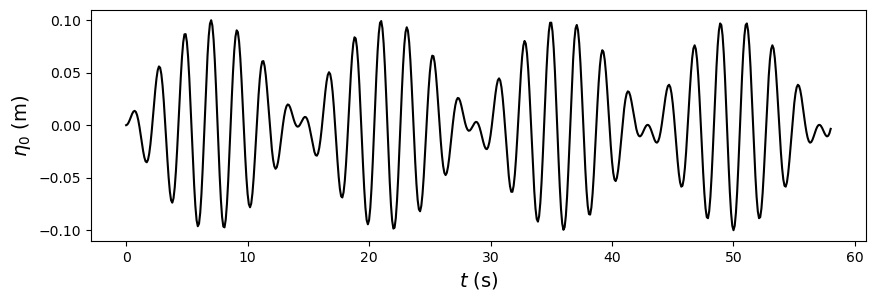

In [11]:
# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(tp, eta0, lw=1.5, color='k')
font_size = 14
ax.set_xlabel('$t$ (s)', fontsize=font_size)
ax.set_ylabel(r'$\eta_0$ (m)', fontsize=font_size)
plt.show()

### Shoal wave
Shoal waves to breaking assuming linear wave theory

In [12]:
wave =  waveshoal_h_nonmono(T, H0, theta0, gammab, h)
wave_group =  waveshoal_h_nonmono(Tg, 0.1, theta0, gammab, h)
wave_half =  waveshoal_h_nonmono(T, H0/2, theta0, gammab, h)

L = wave['L']
H = wave['H']
ib = wave['breaking_index'] + 1 # offset maybe due to the transistion between matlab and python?
hb = wave['breaking_depth'] # water depth at breaking
Hb = wave['breaking_height'] # wave height at breaking
theta = wave['theta']
ab = Hb / 2 # amplitude at breaking
Lb = L[ib] # wavelength at breaking
thetab = theta[ib] # angle at breaking
etab = eta0 * (Hb / H0) # as a proxity for the water surface elevation near breaking, increase eta based on shoaling. 
etab[np.isnan(etab)] = 0
# NOTE that linear wave theory does NOT hold here and therefore, this does not represent the water surface near breaking accurately.

Testing if we are in transitional or shallow water:

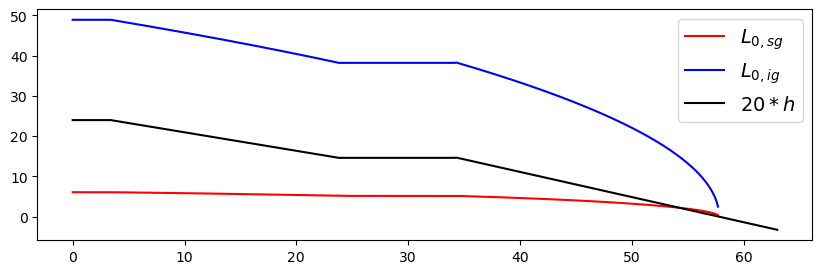

In [13]:
# wave_group['L'][0]/20
# wave['L'][0]/20

fig, ax = plt.subplots(1, figsize=(10, 3))
plt.plot(x,wave['L'],color='r',label='$L_{0,sg}$')
plt.plot(x,wave_group['L'],color='b',label='$L_{0,ig}$')
plt.plot(x,h*20,color='k',label='$20*h$')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.show()

In [14]:
# # Runup: This needs to be revisted to ensure it is correct
# def calculate_runup(slope, Hsig, L):
#     runup = 1.1 * (0.35 * slope * math.sqrt(Hsig * L) + 0.5 * math.sqrt(Hsig * L) * (0.563 * (slope ** 2) + 0.004))
#     return runup

# runup = calculate_runup(lab_slope, H0, L0)
# irunup = find_closest_index(d, runup+swl)

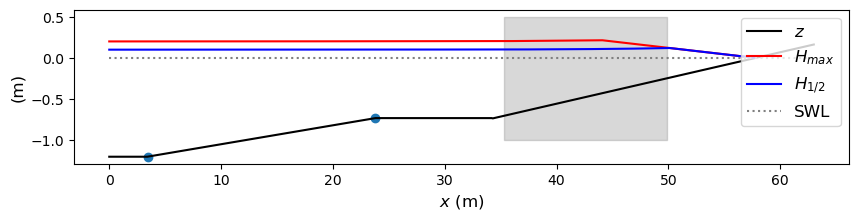

In [15]:
# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(x, d-swl, lw=1.5, color='k', label='$z$')
ax.plot(x, H, lw=1.5, color='r', label='$H_{max}$')
ax.plot(x, wave_half['H'], lw=1.5, color='b', label='$H_{1/2}$')
ax.plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
# ax.plot([x[irunup], x[irunup]], [-1, 0.5], lw=1.5, color='g', linestyle='-', label=r'$\eta_{2\%}$')
ax.scatter([x[ioffbeach[0]], x[ioffbeach[-1]]], [-h[ioffbeach[0]], -h[ioffbeach[-1]]])
ax.fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3)
font_size = 12
ax.set_xlabel('$x$ (m)', fontsize=font_size)
ax.set_ylabel('(m)', fontsize=font_size)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.show()

### Orbital velocities

**Orbital velocities and excursion at bottom boundary**
$$
\tilde{u}_{b} = a \omega \frac{\cosh [k (z+d)]]}{\sinh (kd)} cos \theta
$$
in shallow water, this form converges (but prefer to use above)
$$
\tilde{u}_{b} = a \frac{gT}{L} \frac{\cosh [2 \pi (z+d)/L]]}{\sinh (2 \pi d/L)} cos \theta
$$
where $\tilde{u}_{b} = \sqrt{2}u_{rms}$.

$$
\tilde{a}_{b} = \frac{\tilde{u}_{b}}{\omega}
$$

Here, we use values at breaking and at the wavemaker:

In [34]:
def wave_orbital_velocity(a, T, L, z, h, theta):
    g = 9.81
    u = a *  np.pi * 2 / T * ((np.cosh(2*np.pi*(z+h)/L)) / (np.sinh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    w = a *  np.pi * 2 / T * ((np.sinh(2*np.pi*(z+h)/L)) / (np.sinh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    # below was other option because converge in shallow water
    # u = a * g * T / L * ((np.cosh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    # w = a *  g * T / L * ((np.sinh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    ao = u / (2 * np.pi / T)
    return u, w, ao

Calculate bottom orbital velocities and excursion at breaking

In [35]:
[ubb, wbb, aob] = wave_orbital_velocity(etab, T, Lb, -hb, hb, thetab)
[ubb_max, wbb_max, aob_max] = wave_orbital_velocity(ab, T, Lb, -hb, hb, thetab)
print(f"ubmax at breaking = {ubb_max:.3f} m")
print(f"abmax at breaking = {aob_max:.3f} m")

ubmax at breaking = 0.453 m
abmax at breaking = 0.155 m


Calculate bottom oribital velocities and excursion at wavemaker

In [18]:
[ub0, wb0, ao0] = wave_orbital_velocity(eta0, T, L0, -h0, h0, theta0)
[ub0_max, wb0_max, ao0_max] = wave_orbital_velocity(a0, T, L0, -h0, h0, theta0)

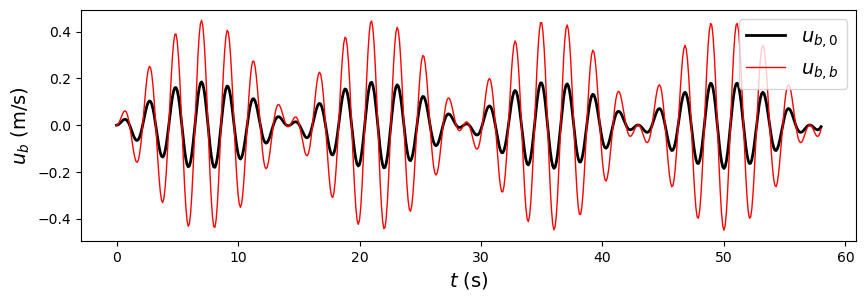

In [19]:
# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(tp, ub0, lw=2, color='k', label='$u_{b,0}$')
ax.plot(tp, ubb, lw=1, color='r', label='$u_{b,b}$')
font_size = 14
ax.set_xlabel('$t$ (s)', fontsize=font_size)
ax.set_ylabel('$u_{b}$ (m/s)', fontsize=font_size)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.show()

### Ustar
**Ustar from the frictional velocity or shear velocity**  
The frictional coefficient is
$$
f_w = \exp\left[ 5.213 \left( \frac{2.5 d_{50}}{\tilde{a}_{b}} \right) ^{0.194} -5.977 \right]
$$

**Shear velocity**
bed shear stress is
$$
\tau_{bw} = \frac{2}{3\pi}\rho_ff_w \tilde{u}_{b}^2~~[\mathrm{N/m}^2]
$$
such that
$$
u_* = \sqrt{\frac{\tau_{bw}}{\rho_f}} = \sqrt{\frac{2f_w}{3\pi}} \tilde{u}_{b}
$$

**Frictional velocity**
$$
u_* = \sqrt{f_w} u_{rms} = \sqrt{\frac{f_w}{2}}\tilde{u}_{b}
$$

Note, the shear velocity is less than the frictional velocity method by a factor of 0.65. 

**<span style="color:red;">For now, proceed with the shear velocity method at breaking.</span>**

In [20]:
def calculate_fw(D50, ab):
    fw = np.exp(5.213 * (2.5 * D50 / ab) ** 0.194 - 5.977)
    return fw

def calculate_taub(rhof, fw, ub):
    taub = (2 / (3 * np.pi)) * rhof * fw * (ub ** 2)
    return taub

def calculate_ustar(tau, rhof):
    ustar = np.sqrt(tau / rhof)
    return ustar

In [21]:
fw = calculate_fw(D50, aob_max)
taub = calculate_taub(rhof, fw, ubb_max)
ustar = calculate_ustar(taub, rhof)
print(f"ustar = {ustar:.3f}")

ustar = 0.023


## Hydrodynamic scaling parameters

### Reynolds number 
The flow conditions near the bed can be divided in laminar, smooth turbulent and rough turbulent. These regimes can be predicted with the grain size Reynolds number:
$$
Re_{gs} = \frac{\tilde{u}_{b,\mathrm{max}} d_{50}}{\nu} =\frac{\sqrt{2} u_{rms} d_{50}}{\nu}
$$
and the wave boundary layer Reynolds number:
$$
R_{wbl} = \frac{ \tilde{u}_{b,\mathrm{max}} a_b}{\nu}=\frac{\sqrt{2}u_{rms}a_b}{\nu}
$$

In [22]:
def calculate_Re_wbl(ub, ab, nu):
    Re = ub * ab / nu
    if Re <= 2000:
        print('Laminar Flow')
    elif Re > 2000 and Re <= 4000:
        print('Unstable Flow')
    elif Re > 4000:
        print('Turbulent Flow')
    return Re

def calculate_Re_gs(ustar, D50, nu):
    Re = ustar * D50 / nu
    return Re

In [23]:
Re_wbl = calculate_Re_wbl(ubb_max, aob_max, nu)
Re_gs = calculate_Re_gs(ustar, D50, nu)
print(f"ReWBL = {Re_wbl:.3f} and ReGS = {Re_gs:.3f}")

Turbulent Flow
ReWBL = 49607.924 and ReGS = 2.525


### Froude number
$$
Fr = \frac{H \omega}{2 \sqrt{gh}}
$$
or an alternative: 
$$
Fr = \frac{\tilde{a}_{b}}{2 \sqrt{gh}}
$$

$Fr<1$ subcritial  
$Fr = 1$ critical  
$Fr > 1$ supercirtical (fast rapid)

In [24]:
def calculate_Fr(H, omega, g, h):
    Fr = H * omega / (2 * np.sqrt(g * h))
    # Fr = ub/(2*np.sqrt(g*h))
    if Fr < 1:
        print('Subcritical')
    elif Fr == 1:
        print('Critical')
    elif Fr > 1:
        print('Supercritical')
    return Fr

In [25]:
Fr = calculate_Fr(Hb, omega, g, hb)
print(f"Fr = {Fr:.4f}")

Subcritical
Fr = 0.1537


### Iribarren Number
This is typically based on deep water wave conditions.
$$
 \zeta = \frac{\beta}{\sqrt{H_s/L_0}}
$$

$\zeta$ <0.4: Spilling  
$0.4<\zeta<2$: Plunging  
$\zeta>2$: Collapsing or surging

In [26]:
def calculate_zeta(beta, H, T):
    g = 9.81
    d = 1000
    L0 = T * np.sqrt( g * d )
    zeta = beta / np.sqrt(H / L0)
    if zeta <= 0.4:
        print('Spilling')
    elif zeta > 0.4 and zeta <= 2:
        print('Plunging')
    elif zeta > 2:
        print('Collapsing or surging')
    return zeta

In [27]:
zeta = calculate_zeta(lab_slope, H0, T)
print(f"zeta = {zeta:.3f}")

Plunging
zeta = 1.020


### Ursell number
The Ursell number relates the skewness and asymmetry and quantifies the nonlinearity:
$$
Ur = \frac{3}{8} \frac{H_{m,0} k}{(kh)^3}
$$
For small Ursell numbers, the skewness and asymmetry both approach zero and the waves have a sinusoidal shape, and thus waves having small Ursell numbers do not result in net sediment transport. For $Ur\sim 1$, the skewness is maximum and the asymmetry is small and the waves have a skewed shape. For large Ursell numbers, the skewness approaches 0 and the asymmetry is maximum, resulting in an asymmetric wave shape. In this way, if the wave shape is known, the Ursell number can be predicted and consequently the size and direction of sediment transport at a certain location can be predicted. 

Skewness:
$$
Sk = B \cos(\psi)
$$
Assymetry:
$$
As = B \sin (\psi)
$$
where
$$
B = \frac{0.857}{1+\exp{\frac{-0.471-\log(Ur)}{0.297}}}
$$
and
$$
\psi = -90^{\circ}+90^{\circ}\tanh\left(\frac{0.815}{Ur^{0.672}}\right)
$$

**<span style="color:red;">Need to figure out regimes.</span>**

In [28]:
def calculate_ursell(H, k, h):
    # Calculate Ur
    Ur = (3/8) * H * k / ((k * h) ** 3)
    
    # Calculate B
    B = 0.857 / (1 + math.exp((-0.471 - math.log(Ur) / 0.297)))
    
    # Calculate psi
    psi = -math.pi/2 + (math.pi/2) * math.tanh(0.815 / (Ur ** 0.672))
    
    # Calculate Sk and As
    Sk = B * math.cos(psi)
    As = B * math.sin(psi)
    
    return Ur, Sk, As

In [29]:
kb = 2 * np.pi / Lb
[Ur, Sk, As] = calculate_ursell(Hb, kb, hb)
print(f"Ur = {Ur:.3f}")
print(f"Sk = {Sk:.3f}")
print(f"As = {As:.3f}")

Ur = 0.444
Sk = 0.080
As = -0.014


### Normalized Beach Slope
See Bertin et al., 2017

In [30]:
# betah = (beachslope * (T * 2)  / (2 * pi)) * sqrt(g / (H/3)) 

## Sediment transport scaling parameters

### Setting velocity: 
Assuming laminar settling, spherical particle, discrete particle, steady state, Stokes settling velocity is computed as:
$$
W_s = \frac{D^2\Delta \rho g}{18 \mu}
$$
where $D$ is the particle diameter ($D_{mm} = 2^{-\phi}$), $\Delta\rho$ is the difference between the density of the sediment ($\rho_s$) and fluid ($\rho_f$), $g$ is gravity, and $\mu$ is dynamic viscosity of the fluid.

In [31]:
def calculate_ws(D50, drho, g, mu):
    ws = ((D50 ** 2) * drho * g) / (18 * mu)
    return ws

In [32]:
# settling velocity
ws = calculate_ws(D50, drho, g, mu)
print(f"Ws = {ws:.4f} m/s")

Ws = 0.0146 m/s


### Dean number
$$
\Omega = \frac{H_{rms}}{w_s T_p}
$$

$\Omega$ <1: reflective beach  
$1<\Omega<6$: intermediate beach   
$\Omega>6$: dissipative beach

In [33]:
def calculate_Omega(H, ws, T):
    Omega = H / (ws * T)
    if Omega <= 1:
        print('Reflective')
    elif Omega > 1 and Omega <= 6:
        print('Intermediate')
    elif Omega > 6:
        print('Dissipative')
    return Omega

In [34]:
Omega = calculate_Omega(Hb, ws, T)
print(f"Omega = {Omega:.3f}")

Dissipative
Omega = 6.899


## Rouse number
$$
Rou = \frac{w_s}{\kappa u^*}
$$

Assuming the von Karmen''s constant $\kappa \approx 0.41$

$Rou$ <0.8: Wash load  
$0.8<Rou<1.2$: Suspended load (100%)  
$1.2<Rou<2.5$: Suspended load (50%)  
$Rou>2.5$: Bed load

In [35]:
def calculate_Rou(ws, kappa, ustar):
    Rou = ws / (kappa * ustar)
    if Rou <= 0.8:
        print('Wash load')
    elif Rou > 0.8 and Rou <= 1.2:
        print('Suspended load (100%)')
    elif Rou > 1.2 and Rou <= 2.5:
        print('Suspended load (50%)')
    elif Rou > 2.5:
        print('Bed load')
    return Rou

In [36]:
Rou = calculate_Rou(ws, kappa, ustar)
print(f"Rou = {Rou:.3f}")

Suspended load (50%)
Rou = 1.515


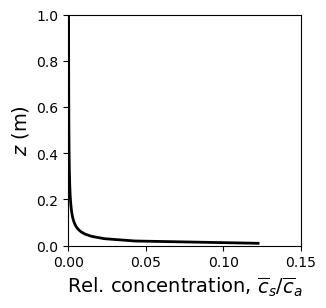

In [37]:
# plot relative suspended-sediment concentration profiles
za = 0.25 / 100
z = np.arange(0.01, 1.01, 0.01)
cc5 = (z / za) ** (-Rou)

fig, ax = plt.subplots(1, figsize=(3, 3))
ax.plot(cc5, z, lw=2, color='k')
font_size = 14
ax.set_xlabel(r'Rel. concentration, $\overline{c}_s/\overline{c}_a$', fontsize=font_size)
ax.set_ylabel('$z$ (m)', fontsize=font_size)
ax.set_xlim([0, 0.15])
ax.set_ylim([0, 1])
plt.show()

## Shields Number

$$
\theta_{\omega} = \frac{\langle \tau_{bw} \rangle}{(\rho_s-\rho_f)gd_{50}}
$$

$$
Re_* = \frac{ \sqrt{\frac{\tau_{bw}}{ \rho_f}}d_{50}}{\nu}
$$

In [38]:
def calculate_shields(taub, rhos, rhof, D50, nu):
    g = 9.81
    shields = taub / ((rhos-rhof) * g * D50)
    Restar = np.sqrt(taub / rhof) * D50 / nu
    return shields, Restar

In [39]:
[shields, Restar] = calculate_shields(taub, rhos, rhof, D50, nu)
print(f"shields number = {shields:.3f} and Restar = {Restar:.3f}")

shields number = 0.226 and Restar = 2.525


### Stokes Number 
<!-- **<span style="color:red;">Not certain about this number.</span>**  
The settling velocity (also called the "fall velocity" or "terminal velocity") is a function of the particle Reynolds number. Generally, for small particles (laminar approximation), it can be calculated with Stokes' Law. For larger particles (turbulent particle Reynolds numbers), fall velocity is calculated with the turbulent drag law. Dietrich (1982) compiled a large amount of published data to which he empirically fit settling velocity curves. Ferguson and Church (2006) analytically combined the expressions for Stokes flow and a turbulent drag law into a single equation that works for all sizes of sediment, and successfully tested it against the data of Dietrich.

$$
w_s = \frac{RgD^2}{C_1 \nu+(0.75 C_2 RgD^3)^{0.5}}
$$

where $R$ is specific gravity and $C_1$ and $C_2$ are constants related to shape and smoothess. Here I choose conditions for natural grains with sieve diameters $C_1$ =18, $C_2$ = 1 (for nominal diamters $C_1$ =20, $C_2$=1.1)

For known quantities and seive diamater for natural grains:
$$
w_s = \frac{16.17 D^2}{1.8\times 10^{-5}+(12.1275D^3)^{0.5}}
$$

**OR** -->
A dimensionless number characterising the behavior of particles suspended in a fluid flow. Ratio of the characteristic time of a particle to characteristic time of the flow
$$
Stk =\frac{t u }{l}
$$
where $t$ is the relaxation time, $u$ is the fluid velocity well away from the obstacle, $l$ is the characteristic dimension of the obstacle. In other words:
$$
Stk = \frac{t u_*}{d_{50}}
$$
where
$$
t = \frac{\rho_s d_{50}^2}{18 \mu}
$$
Thus,
$$
Stk = \frac{\rho_s D u_*}{18 \mu }
$$

In [40]:
# stokes fall velocity
# def calculate_stk(D50):
#     stk = 16.17 * D50**2 / ((1.8e-5) + (12.1275 * D50**3)**0.5)
#     return stk

# another stokes? 
def calculate_Stk(rhos, D50, mu, ustar):
    Stk = (rhos * D50 * ustar) / (18 * mu)
    return Stk

In [41]:
# stk = calculate_stk(D50)
# print(f"stk = {stk:.3f}")
Stk = calculate_Stk(rhos, D50, mu, ustar)
print(f"Stk = {Stk:.3f}")

Stk = 0.373


### Sleath number
The relative density of sediment is important when considering particle accelerations. Horizontal pressure gradients and inertia forces can have a significant impact on the total force balance of a sediment particle. This impact can be expressed with the Sleath parameter
$$
S = \frac{\rho u \omega}{(\rho_s - \rho)g}
$$

which is the ratio of inertial forces to gravitational forces acting on individual grains of sediment. High Sleath numbers ($S>0.2$) suggests that sediment will start to move earlier than predicted by the Shields curve. In addition, the mode of transport can become different and sediment will start to move as a block, also known as plug flow. 

High sleath numbers (S>0.2) suggest that sidement will start to move earlier than shields predicted

In [42]:
def calculate_Sleath(rhof, ustar, omega, drho, g):
    S = (rhof * ustar * omega) / (drho * g)
    if S < 0.2:
        print('sediment movement predicted by Shields')
    else:
        print('sediment start to move earlier than prediced by shields')
    return S

In [43]:
S = calculate_Sleath(rhof, ustar, omega, drho, g)
print(f"Sleath = {S:.4f}")

sediment movement predicted by Shields
Sleath = 0.0042


### Mobility Number
$$
\Phi = \frac{u_b^2}{(s-1)gd_{50}}
$$
where $U_b = a\pi/T$ is the wave orbital velocity amplitude, $2a$ is the wave orbital excretion, $s$ is the specific sediment density (about 2.65). The critical value of the mobility parameter based on flume experiments is $\Phi\approx 8$.

In [44]:
def calculate_Phi(ub, sdense, D50):
    g = 9.81
    Phi = (ub ** 2) / ((sdense - 1) * g * D50)
    if Phi >= 8:
        print('critical value exceeded')
    else:
        print('critical value not exceeded')
    return Phi

In [45]:
Phi = calculate_Phi(ubb_max, sdense, D50)
print(f"Phi = {Phi:.4f}")

critical value exceeded
Phi = 82.8258


### Bagnold Number 
Assuming $C=1$:
$$
q = C\frac{\rho}{g}\sqrt{\frac{d_{50}}{D}}u_*^3
$$

where $q$ represents the mass transport of sand across a lane of unit width, $C$ is a dimensionless constant of order unity that depends on the sand sorting, $D$ is the nearly uniform grain size originally used in Bagnold's experiments (250 microm), and $u_*$ is frictional velcoity propotional to the square root of the shear stresses between the flow and the sheet of moving sand.

In [46]:
def calculate_q(C, rhof, D50, Dbag, ustar):
    g = 9.81
    q = C * rhof / g * math.sqrt(D50 / Dbag) * ustar ** 3
    return q

In [47]:
C = 1
Dbag = 0.00025
q = calculate_q(C, rhof, D50, Dbag, ustar)
print(f"q = {q:.4f}")

q = 0.0010


## Other Scaling

### Roughness/sheet-flow thickness length
Roughness length 
$$
k_s = 5 \theta d_{50}
$$
Sheet-flow thickness length
$$
\delta_s = 10 \theta d_{50}
$$

### Archamedes number
$$
Ar = \frac{g L^3 (\rho - \rho_l)/\rho_l}{\nu^2} = \frac{g L^3 \rho_l (\rho - \rho_l)}{\mu^2}
$$
$L$ is a characteristic length, $(\rho - \rho_l)/\rho_l$ is the submerged specific gravity

### Bond number
$$
Bo = \frac{\Delta \rho g L^2}{\gamma} 
$$
where $L$ is a characteristic length and $\gamma$ is surface tension.

$$
Bo = \frac{L}{\lambda_c}^2
$$
where $\lambda_c = \sqrt{\gamma/\rho g}$